# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [7]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [8]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [9]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [10]:
def AutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1] ,))
    encoded = Dense(dim, activation='tanh')(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [11]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [12]:
GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

this data had finished making


array([[ 0.8825,  0.8755,  0.8711, ...,  0.9233,  0.925 ,  0.9206],
       [ 0.8674,  0.8728,  0.8821, ...,  0.8264,  0.824 ,  0.8271],
       [ 0.8371,  0.8437,  0.8447, ...,  0.8532,  0.8471,  0.8498],
       ..., 
       [-0.1003, -0.0998, -0.0912, ..., -0.0995, -0.0942, -0.0925],
       [-0.1   , -0.1025, -0.1022, ..., -0.0939, -0.0986, -0.0966],
       [-0.0939, -0.0978, -0.0981, ..., -0.0976, -0.1015, -0.0973]])

# denoizng AutoEncoder

ノイズの加え方はとても簡単  

``` python
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
```

以上のように入力データに加えるだけ
いきなり，学習するのではなくノイズを加えたらどのように変化するのかみてみよう

In [13]:
windowRaw = GetWindowFrame('AccX',Sensor1['AccX'],256,32,WindowDataPath)

this data had finished making


In [14]:
noiseFactor =0.5

In [30]:
windowRaw.var()

0.12330850596507018

In [26]:
np.random.normal(loc=0.0,scale=1.0,size=windowRaw.shape).var()

1.0002109222542894

In [27]:
windowNoise = windowRaw + noiseFactor*np.random.normal(loc=0.0,scale=1.0,size=windowRaw.shape)

In [28]:
print windowRaw.shape
print windowNoise.shape

(33676, 256)
(33676, 256)


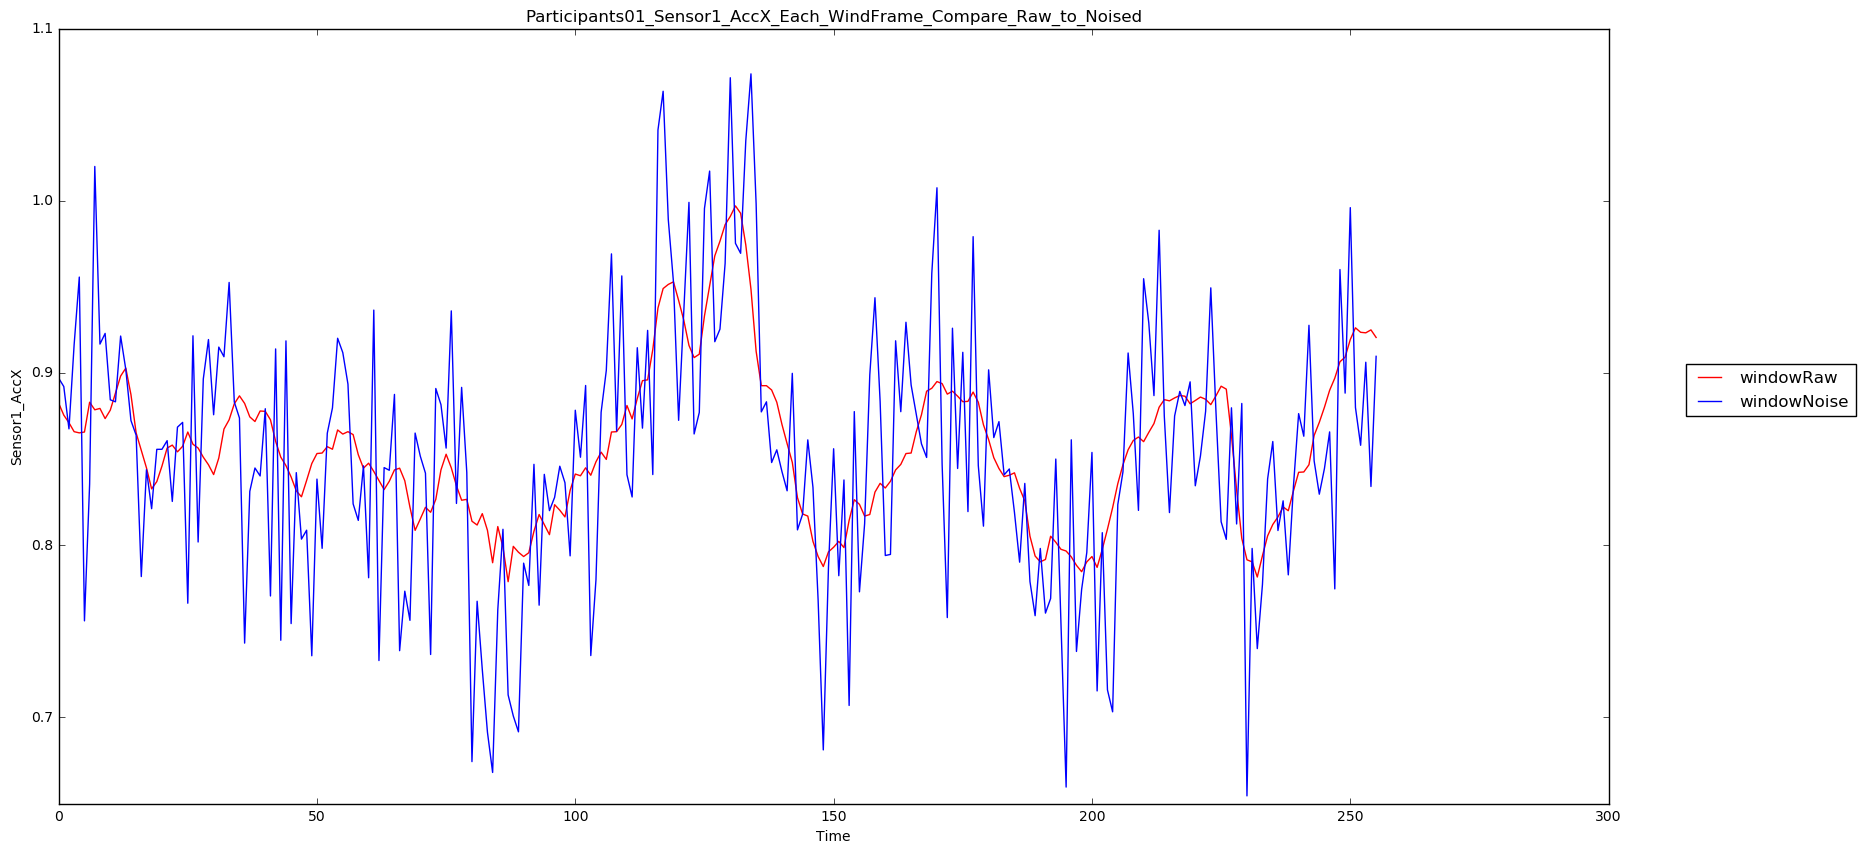

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')
RngPlotWidth = 5

ax.plot(range(256), windowRaw[0,:],'r',label='windowRaw')
ax.plot(range(256), windowNoise[0,:],'b',label='windowNoise')

lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame_Compare_Raw_to_Noised")
ax.set_ylabel("Sensor1_AccX")


# スクリプトの目的
ノイズありとノイズなしのデータを見たため，AutoEncoderによってどれくらい変化するのか見てみる
学習については，これのコピー元である"Keras-Participants01-Sensor1-AccX"と同様なものにする
たたし，多少変更する変更点は
* VaridationDataをノイズなしのデータに，TrainDataをノイズありデータにする
* CommonNameの最後に'denoising'を付け加える

In [18]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windowRaw,AEDimention,Optim,CommonName,BatchSize)

this data had finished making
hiden node = 16
_AEdim=016_Win=0256_Sld=0032_Adam_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.2762 - val_loss: 0.0067
Epoch 2/50
0s - loss: 0.2440 - val_loss: 0.0053
Epoch 3/50
0s - loss: 0.2419 - val_loss: 0.0047
Epoch 4/50
0s - loss: 0.2411 - val_loss: 0.0046
Epoch 5/50
0s - loss: 0.2400 - val_loss: 0.0196
Epoch 6/50
0s - loss: 0.2400 - val_loss: 0.0041
Epoch 7/50
0s - loss: 0.2389 - val_loss: 0.0154
Epoch 8/50
0s - loss: 0.2387 - val_loss: 0.0188
Epoch 9/50
0s - loss: 0.2385 - val_loss: 0.0192
Epoch 10/50
0s - loss: 0.2382 - val_loss: 0.0158
Epoch 11/50
0s - loss: 0.2379 - val_loss: 0.0119
Epoch 12/50
0s - loss: 0.2375 - val_loss: 0.0057
Epoch 13/50
0s - loss: 0.2372 - val_loss: 0.0110
Epoch 14/50
0s - loss: 0.2370 - val_loss: 0.0170
Epoch 15/50
0s - loss: 0.2369 - val_loss: 0.0121
Epoch 16/50
0s - loss: 0.2367 - val_loss: 0.0076
Epoch 17/50


KeyboardInterrupt: 

学習の過程を見ると，明らかにおかしな学習をしていることがわかる．これの原因としてを列挙する
* 学習の際に入力データをシャッフルせず，時系列順に渡しているから
* 最適化方法が合ってない
* バッチサイズが最適値でない  
他にも原因あるが，とりあえず一番の内容はもう少し考える．
まずは，最適化方法を試す．

In [ ]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_denoising'
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windowNoise,AEDimention,Optim,CommonName,BatchSize)

バッチサイズを変更してみる，まずは試しに先ほどの半分で学習する

In [ ]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 16
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_denoising'
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windowRaw,AEDimention,Optim,CommonName,BatchSize)

電話を受けてやっていくこと  
まず，学習方法のパラメータを変更して見ていく．  
まず，中間層の値を変えてみるー＞入力データと同じ，２分の１，４分の１，８分の１でやる  
次に，最適化法保をＳＧＤ試す  

In [ ]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum,WindowNum/2,WindowNum/4,WindowNum/8])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_denoising'
        print CommonName
      
        AutoEncoder(windowNoise,windowRaw,AEDimention,Optim,CommonName,BatchSize)

上の結果を見る限り，いい感じに学習できていることがわかった．興味として，上記の中間層の次元以外のパラメータを固定して，さらに次元を圧縮してみる．具体的には，1/8より圧縮してみる．



In [ ]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum/8,WindowNum/16,WindowNum/32,WindowNum/64])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim+'_denoising'
        print CommonNam

        AutoEncoder(windowNoise,windowRaw,AEDimention,Optim,CommonName,BatchSize)

In [ ]:
print 'finish'